In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from gmm_dataset import *
from util_hmm_gibbs import *
from util_plots import *
from scipy.stats import invwishart
from torch.distributions.dirichlet import Dirichlet

In [2]:
Xs = sampling_hmm()

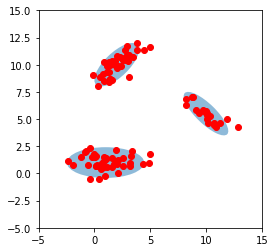

In [3]:
plot_samples(Xs)
Y = torch.from_numpy(Xs).float()

In [4]:
T = 100
K = 3
D = 2
iterations = 100
alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0 = pirors(Y, T, D, K)

In [5]:
## initialization
cov_ks = torch.zeros((K, D, D))
mu_ks = torch.zeros((K, D))
for k in range(K):
## sample mu_k and Sigma_k randomly
    cov_ks[k] = torch.from_numpy(invwishart.rvs(df=nu_0, scale=W_0.data.numpy())).float()
    mu_ks[k] = MultivariateNormal(loc=m_0, covariance_matrix=cov_ks[k] / beta_0).sample()
Pi = Dirichlet(alpha_init_0).sample()
A = torch.zeros((T, K)).float()
for k in range(K):
    A[k] = Dirichlet(alpha_trans_0[k]).sample()

In [6]:
LLs = torch.zeros(iterations)
for it in range(iterations):
#     Zs = sample_assignments(mu_ks, cov_ks, Y, T, D, K)
    Zs = gibbs_local(Pi, A, mu_ks, cov_ks, Y, T, D, K)
    N_ks, Y_ks, S_ks = stats(Zs, Y, D, K)
    Pi, A, mu_ks, cov_ks = gibbs_global(Zs, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, T, D, K)
    LLs[it] = log_joint(alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Zs, Pi, A, mu_ks, cov_ks, Y, T, D, K).item()

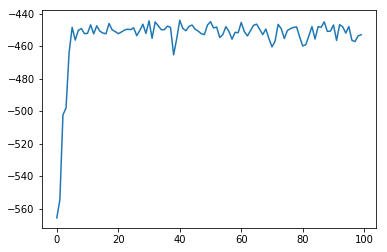

In [7]:
plt.plot(LLs.data.numpy())

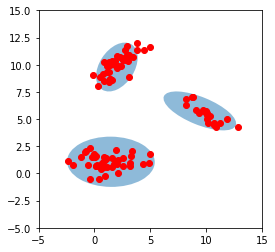

In [8]:
plot_clusters(Xs, mu_ks.data.numpy(), cov_ks.data.numpy())

In [14]:
A

tensor([[0.6199, 0.0976, 0.2825],
        [0.3082, 0.2301, 0.4617],
        [0.3365, 0.1098, 0.5536]])